## Sprint25課題 Seq2Seq

## この課題の目的

- RNNの活用例を知る

## 機械翻訳

RNNの最も基本的な活用例としては機械翻訳があります。これは時系列を入力し、時系列を出力するSequence to Sequenceの手法によって行えます。

## 【問題1】機械翻訳の実行とコードリーディング

Keras公式のサンプルコードで、短い英語からフランス語への変換が行えるのでこれを動かしてください。

[keras/lstm_seq2seq.py at master · keras-team/keras](https://github.com/keras-team/keras/blob/master/examples/lstm_seq2seq.py)

その上でこのサンプルコードの各部分がどういった役割かを読み取り、まとめてください。以下のようにどこからどこの行が何をしているかを記述してください。

（例）

- 51から55行目 : ライブラリのimport
- 57から62行目 : ハイパーパラメータの設定

In [1]:
#ライブラリのインポート
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

#ハイパーパラメータ
batch_size = 64 # Batch size for training.
epochs = 30 # Number of epochs to train for.(changed 100 to 30)
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000   # Number of samples to train on.

#データのpath
data_path = 'fra-eng/fra.txt'

#空リスト
input_texts = []
target_texts = []

#空集合
input_characters = set()
target_characters = set()

#データの読み込み
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
    
#データをinputとtargetに分ける
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    
    #targetに\tと\nをつける
    target_text = '\t' + target_text + '\n'
    
    #リストへ
    input_texts.append(input_text)
    target_texts.append(target_text)
    
    #文字ごとに分けて集合へ(被っていたら入れない)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

#sort
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))

#文字の総数
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)

#単語の最大の長さ
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

#出力
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

#文字と数字を紐づけた辞書{文字: 数字}
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

#0配列 
#エンコーダーのinputの3次元の0配列(単語数, inputの最大長の単語, 文字数)
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
#デコーダーのinputの3次元の0配列(単語数, targetの最大長の単語 文字数)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
#デコーダーのtargetの3次元の0配列(単語数, targetの最大長の単語, 文字数)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

#単語と文字が一致するところを1にする
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.
        
        #decoder_target_dataは最初の文字を除く
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

#エンコーダー
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

#STATE
encoder_states = [state_h, state_c]

#デコーダー
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

#モデルの作成
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

#コンパイル
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

#学習
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

#モデルを保存
model.save('s2s.h5')

# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

#予測モデル
#エンコーダーのモデル作成
encoder_model = Model(encoder_inputs, encoder_states)

#デコーダー
#デコーダへの入力
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

#Layerの設定
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

#モデルの作成
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

#数字と文字が紐づいた辞書{数字: 文字}
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    #予測
    states_value = encoder_model.predict(input_seq)

    #0配列(1, 1, targetの文字数)
    target_seq = np.zeros((1, 1, num_decoder_tokens))

    #最初の文字の位置を1にする
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    
    #stop_conditionがFalseの間続ける
    while not stop_condition:
        
        #デコード後の予測
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        #確率の高い文字を追加
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        #\n or 単語の長さが最大になったらstop_conditionをTrueに
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        #target_seqをリセットして、該当する文字の位置を1にする
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        #states_valueを更新
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

Using TensorFlow backend.


Number of samples: 10000
Number of unique input tokens: 70
Number of unique output tokens: 93
Max sequence length for inputs: 16
Max sequence length for outputs: 59
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 8000 samples, validate on 2000 samples
Epoch 1/30
8000/8000 [==============================] - 32s 4ms/step - loss: 0.9199 - val_loss: 0.9341
Epoch 2/30
8000/8000 [==============================] - 33s 4ms/step - loss: 0.7300 - val_loss: 0.7585
Epoch 3/30
8000/8000 [==============================] - 35s 4ms/step - loss: 0.6178 - val_loss: 0.6859
Epoch 4/30
8000/8000 [==============================] - 32s 4ms/step - loss: 0.5602 - val_loss: 0.6258
Epoch 5/30
8000/8000 [==============================] - 33s 4ms/step - loss: 0.5206 - val_loss: 0.5885
Epoch 6/30
8000/8000 [==============================] - 33s 4ms/step - los

/Users/yuhisoejima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/keras/engine/network.py:877: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


-
Input sentence: Go.
Decoded sentence: Laissez tomber !

-
Input sentence: Hi.
Decoded sentence: Reste troche.

-
Input sentence: Run!
Decoded sentence: Suis-le !

-
Input sentence: Run!
Decoded sentence: Suis-le !

-
Input sentence: Who?
Decoded sentence: Quis a mal ?

-
Input sentence: Wow!
Decoded sentence: Continue !

-
Input sentence: Fire!
Decoded sentence: Attaquez !

-
Input sentence: Help!
Decoded sentence: Bon jouner !

-
Input sentence: Jump.
Decoded sentence: Allez !

-
Input sentence: Stop!
Decoded sentence: Arrêtez !

-
Input sentence: Stop!
Decoded sentence: Arrêtez !

-
Input sentence: Stop!
Decoded sentence: Arrêtez !

-
Input sentence: Wait!
Decoded sentence: Attends !

-
Input sentence: Wait!
Decoded sentence: Attends !

-
Input sentence: Go on.
Decoded sentence: Rentre à la maison.

-
Input sentence: Go on.
Decoded sentence: Rentre à la maison.

-
Input sentence: Go on.
Decoded sentence: Rentre à la maison.

-
Input sentence: Hello!
Decoded sentence: Salut !

-
Inp

## イメージキャプショニング

他の活用例としてイメージキャプショニングがあります。画像に対する説明の文章を推定するタスクです。これは画像を入力し、時系列を出力するImage to Sequenceの手法によって行えます。

[pytorch-tutorial/tutorials/03-advanced/image_captioning at master · yunjey/pytorch-tutorial](https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/image_captioning)

イメージキャプショニングは学習に多くの時間がかかるため、ここでは学習済みの重みが公開されている実装を動かすことにします。Kerasには平易に扱える実装が公開されていないため、今回はPyTorchによる実装を扱います。



## 【問題2】イメージキャプショニングの学習済みモデルの実行

上記実装において5. Test the modelの項目を実行してください。また、自身で用意した画像に対しても文章を生成してください。これらに対してどういった文章が出力されたかを記録して提出してください。

データセットからの学習は行わず、学習済みの重みをダウンロードして利用します。

注意点として、デフォルトで設定されている重みのファイル名と、ダウンロードできる重みのファイル名は異なっています。ここは書き換える必要があります。

In [1]:
%cd pytorch-tutorial/tutorials/03-advanced/image_captioning/

/Users/yuhisoejima/python/diveintocode-ml/diveintocode-term2/sprint25/pytorch-tutorial/tutorials/03-advanced/image_captioning


<start> a group of giraffes standing next to each other . <end>


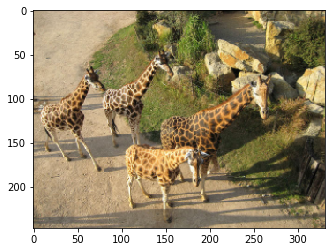

In [3]:
%run sample.py --image='png/example.png'

<start> a large group of people in a large town . <end>


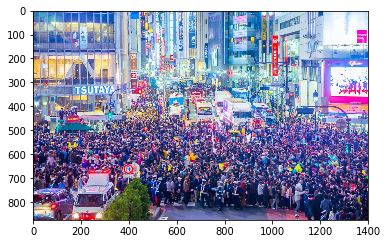

In [15]:
#任意の画像(渋谷のハロウィン)
%run sample.py --image='png/xlarge_4052a78f-0f08-4f29-9ca6-4124b90ccebc.jpeg'

In [17]:
%cd -

/Users/yuhisoejima/python/diveintocode-ml/diveintocode-term2/sprint25


## 【問題3】Kerasで動かしたい場合はどうするかを調査

PyTorchによる実装を動かしましたが、何らかの理由からKerasで動かしたい状況が考えられます。どういった手順を踏むことになるか調査し、できるだけ詳しく説明してください。

特に今回はPyTorchのための学習済みの重みをKerasで使えるようにしたいので、その点については必ず触れてください。

- MMdnnを用いて、Pytorchの学習済みモデルを中間表現に変換する。
- Pytorchで書かれている部分をKeras用にコードを書き換える。  
[MMdnn](https://github.com/Microsoft/MMdnn)

## 【問題4】（アドバンス課題）コードリーディングと書き換え

モデル部分はmodel.pyに書かれていますが、Kerasではこのモデルがどのように記述できるかを考え、コーディングしてください。その際機械翻訳のサンプルコードが参考になります。

## 【問題5】（アドバンス課題）発展的調査

他の言語の翻訳を行う場合は？

問題1の実装を使い日本語と英語の翻訳を行いたい場合はどのような手順を踏むか考えてみましょう。

機械翻訳の発展的手法にはどのようなものがある？

機械翻訳のための発展的手法にはどういったものがあるか調査してみましょう。

文章から画像生成するには？

イメージキャプショニングとは逆に文章から画像を生成する手法もあります。どういったものがあるか調査してみましょう。